In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms

from bounds import *
from dgp import *
from vset import *
import estimation, utils, experiments, vset, plots
import pandas as pd



# Debugging IV identification

In [2]:
Dx, Du = 5, 0
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 2
}

msm_dgp = set_dgp_config(dgp, 'MSM')
data = generate_data(msm_dgp)


## Test learning outcome probabilities

In [3]:
msm_dgp = set_dgp_config(dgp, 'MSM')
data = generate_data(msm_dgp)
estimation.estimate_bounds(msm_dgp, data, id_method='MSM', est_method='oracle', K=5)

,Rs_down,Rs_up,Rd_down,Rd_up,Rs_coverage,Rd_coverage,R_oracle,metric,id_method,est_method
0,-0.442321,0.205203,-0.299383,0.046694,1,1,-0.044788,m_y=1,MSM,oracle
1,-0.453623,0.184842,-0.314613,0.024438,1,1,-0.303794,m_y=0,MSM,oracle
2,-0.621289,0.505295,-0.244548,0.128554,1,1,0.122409,m_a=0,MSM,oracle
3,-0.110657,0.269244,-0.110657,0.269244,1,1,0.124838,m_a=1,MSM,oracle
4,-0.367146,0.388546,-0.122113,0.143513,1,1,0.092100,m_u,MSM,oracle


In [84]:
estimation.estimate_bounds(msm_dgp, data, id_method='MSM', est_method='plugin', K=5)

outcome regression error: 0.043218950581498154
propensitiy error: 0.026068173306555392
outcome regression error: 0.03883126286322675
propensitiy error: 0.025846728054586564
outcome regression error: 0.04162230822009172
propensitiy error: 0.024802039095536528
outcome regression error: 0.039635756080474094
propensitiy error: 0.02578407892389513
outcome regression error: 0.03992138284299188
propensitiy error: 0.025476313405033636


,Rs_down,Rs_up,Rd_down,Rd_up,Rs_coverage,Rd_coverage,R_oracle,metric,id_method,est_method
0,-0.545193,-0.338356,-0.508254,-0.377225,1.0,1.0,-0.449353,m_y=1,MSM,plugin
1,-0.550948,-0.342820,-0.514499,-0.381328,1.0,1.0,-0.458090,m_y=0,MSM,plugin
2,-0.280651,0.218070,-0.195899,0.133319,1.0,1.0,0.001760,m_a=0,MSM,plugin
3,-0.027843,0.057846,-0.027843,0.057846,1.0,1.0,0.007186,m_a=1,MSM,plugin
4,-0.084671,0.085471,-0.028803,0.029603,1.0,1.0,0.002100,m_u,MSM,plugin


# Coverage sample size experiment 
- Construct 95% bootstrap CI around plug-in estimates of the regret. Plot as a function of sample size.
- Also plot coverage as a function of sample size.

In [6]:
Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.5
}

msm_dgp = set_dgp_config(dgp, 'MSM')
Ns = [100, 300, 600, 900, 1200, 1500, msm_dgp['N']-1]
coveragedf = experiments.estimation_coverage_experiment(msm_dgp, Ns, Nsims=30)



outcome regression error: 0.21890783405077174
propensitiy error: 0.2433494957697811
outcome regression error: 0.26349347146033036
propensitiy error: 0.20004202818814792
outcome regression error: 0.25293580698563994
propensitiy error: 0.3201279706116701
outcome regression error: 0.1902054877614868
propensitiy error: 0.15185481970684767
outcome regression error: 0.31150552113006374
propensitiy error: 0.23411820137593842
outcome regression error: 0.16307360349676242
propensitiy error: 0.24322472729159447
outcome regression error: 0.236668970343203
propensitiy error: 0.26249204223061195
outcome regression error: 0.05572194397648846
propensitiy error: 0.21479578449268316
outcome regression error: 0.08037443554204461
propensitiy error: 0.20007815054348507
outcome regression error: 0.15561517191386803
propensitiy error: 0.2004237799724212
outcome regression error: 0.12634658790256909
propensitiy error: 0.19983625626557872
outcome regression error: 0.15816556095342257
propensitiy error: 0.1964

outcome regression error: 0.1810721673530049
propensitiy error: 0.1731475068900788
outcome regression error: 0.20646528115912427
propensitiy error: 0.13325446496837418
outcome regression error: 0.1482776074997508
propensitiy error: 0.22183250270468538
outcome regression error: 0.0938202024608347
propensitiy error: 0.18773771615759438
outcome regression error: 0.13768322602758562
propensitiy error: 0.10835016327087273
outcome regression error: 0.1508815670743668
propensitiy error: 0.23372489039470698
outcome regression error: 0.1225577601551697
propensitiy error: 0.17606734635863985
outcome regression error: 0.1262401212584261
propensitiy error: 0.21495993535986962
outcome regression error: 0.11545655320957364
propensitiy error: 0.24131734970174262
outcome regression error: 0.17474396133267575
propensitiy error: 0.1710920332284809
outcome regression error: 0.1461958618219989
propensitiy error: 0.23641903325715172
outcome regression error: 0.10449247133018887
propensitiy error: 0.2819341

outcome regression error: 0.09192491754977539
propensitiy error: 0.1616123725565979
outcome regression error: 0.10221754201094232
propensitiy error: 0.17765166039076782
outcome regression error: 0.11838414742601974
propensitiy error: 0.18704927015493714
outcome regression error: 0.13120215253612655
propensitiy error: 0.20849972194306193
outcome regression error: 0.1235794645452418
propensitiy error: 0.16924599999732334
outcome regression error: 0.11698140875923621
propensitiy error: 0.2447384753424889
outcome regression error: 0.1351202724955938
propensitiy error: 0.20160419123898754
outcome regression error: 0.11370834048977359
propensitiy error: 0.1951084379194695
outcome regression error: 0.15294587660732142
propensitiy error: 0.17300606015992015
outcome regression error: 0.12196534779251059
propensitiy error: 0.17675377683343785
outcome regression error: 0.095956512262996
propensitiy error: 0.17052828879098014
outcome regression error: 0.10676347683961833
propensitiy error: 0.19096

outcome regression error: 0.10417099363400825
propensitiy error: 0.16561595290551015
outcome regression error: 0.09996546049608844
propensitiy error: 0.18278790509220552
outcome regression error: 0.11139824702523425
propensitiy error: 0.18305730860971678
outcome regression error: 0.11508477247976273
propensitiy error: 0.17646116210193655
outcome regression error: 0.0922136611296016
propensitiy error: 0.19365736846716547
outcome regression error: 0.08442676255198359
propensitiy error: 0.18489239470097044
outcome regression error: 0.09245836612524587
propensitiy error: 0.21582689357939577
outcome regression error: 0.08751313205087621
propensitiy error: 0.19511307866079933
outcome regression error: 0.10786900870838449
propensitiy error: 0.1817230322121827
outcome regression error: 0.08735627796482687
propensitiy error: 0.2010450535192202
outcome regression error: 0.12680090020245113
propensitiy error: 0.17664176314750826
outcome regression error: 0.07758112501996692
propensitiy error: 0.1

outcome regression error: 0.10149526928028434
propensitiy error: 0.17490668475141327
outcome regression error: 0.11643982869579193
propensitiy error: 0.1987405867230091
outcome regression error: 0.0996518079464652
propensitiy error: 0.17033643840483348
outcome regression error: 0.09022675475059865
propensitiy error: 0.2035712894681595
outcome regression error: 0.09043444263120039
propensitiy error: 0.19079321757623222
outcome regression error: 0.1073676868492966
propensitiy error: 0.1611782438246202
outcome regression error: 0.09230199189637775
propensitiy error: 0.16314608909027176
outcome regression error: 0.09481944009025879
propensitiy error: 0.19173819260518948
outcome regression error: 0.10478406524592333
propensitiy error: 0.1809675885252948
outcome regression error: 0.12284957498407996
propensitiy error: 0.1770292754810926
outcome regression error: 0.09246377916480243
propensitiy error: 0.193147386500435
outcome regression error: 0.09718523681344804
propensitiy error: 0.1707258

outcome regression error: 0.08115989736802971
propensitiy error: 0.18215199916437205
outcome regression error: 0.09841376016465479
propensitiy error: 0.182610787858505
outcome regression error: 0.10473498190195174
propensitiy error: 0.1666543980737136
outcome regression error: 0.11586806268398991
propensitiy error: 0.18514068698172115
outcome regression error: 0.09898244686365512
propensitiy error: 0.19598744364761178
outcome regression error: 0.09732594212260434
propensitiy error: 0.19235512977323105
outcome regression error: 0.1002009705324852
propensitiy error: 0.16915174995854323
outcome regression error: 0.09732517276170645
propensitiy error: 0.2053752419737362
outcome regression error: 0.1006471859623863
propensitiy error: 0.1843265983706165
outcome regression error: 0.12749862198929204
propensitiy error: 0.18716975629051688
outcome regression error: 0.10306525129700171
propensitiy error: 0.19037123072305956
outcome regression error: 0.10823356195915418
propensitiy error: 0.17861

outcome regression error: 0.08832534364927286
propensitiy error: 0.18130071419821933
outcome regression error: 0.09534291229963522
propensitiy error: 0.16187484784219855
outcome regression error: 0.10259788661996444
propensitiy error: 0.1883292285697485
outcome regression error: 0.10472504676118674
propensitiy error: 0.17804297140443637
outcome regression error: 0.10741299102982522
propensitiy error: 0.17761617176143543
outcome regression error: 0.10253606919789551
propensitiy error: 0.16568132932492668
outcome regression error: 0.0965867329767524
propensitiy error: 0.19136624436958663
outcome regression error: 0.09244694778633808
propensitiy error: 0.1941472921433699
outcome regression error: 0.08612099114218189
propensitiy error: 0.19619009952964855
outcome regression error: 0.08793370860023424
propensitiy error: 0.1923412859525069
outcome regression error: 0.09095279525239501
propensitiy error: 0.20288141789762512
outcome regression error: 0.08640941420664906
propensitiy error: 0.17

outcome regression error: 0.08705222783149962
propensitiy error: 0.1738749759937748
outcome regression error: 0.08436407726269346
propensitiy error: 0.17574335718924222
outcome regression error: 0.09730601778011008
propensitiy error: 0.1655604323816613
outcome regression error: 0.08601359028840347
propensitiy error: 0.1977263960628136
outcome regression error: 0.10256527207407255
propensitiy error: 0.17723580581282886
outcome regression error: 0.1005013607823356
propensitiy error: 0.18177224828642569
outcome regression error: 0.09236946193311178
propensitiy error: 0.19414356127477211
outcome regression error: 0.10811693562213458
propensitiy error: 0.19794845805462485
outcome regression error: 0.08723299234425853
propensitiy error: 0.17229712812772888
outcome regression error: 0.08518149569683645
propensitiy error: 0.1716402280053801
outcome regression error: 0.0944664138667308
propensitiy error: 0.18151942253810247
outcome regression error: 0.1157619230548236
propensitiy error: 0.18263

outcome regression error: 0.09080725382941124
propensitiy error: 0.18727054063455198
outcome regression error: 0.09323201752581682
propensitiy error: 0.1739739450861852
outcome regression error: 0.08733654554178884
propensitiy error: 0.17655385696912496
outcome regression error: 0.09046021994960503
propensitiy error: 0.1697505664173343
outcome regression error: 0.09857433187563065
propensitiy error: 0.1851145818257029
outcome regression error: 0.09157845950247387
propensitiy error: 0.17648143187487605
outcome regression error: 0.09813623935734031
propensitiy error: 0.16469926889596073
outcome regression error: 0.0956074294548006
propensitiy error: 0.1707641305210044
outcome regression error: 0.09591873948065938
propensitiy error: 0.17611083906679556
outcome regression error: 0.09717292286712331
propensitiy error: 0.18422611632311917
outcome regression error: 0.09177467144055233
propensitiy error: 0.17753568163772343
outcome regression error: 0.11063370393771578
propensitiy error: 0.175

outcome regression error: 0.08944691503501431
propensitiy error: 0.17858084754745146
outcome regression error: 0.08569803349284853
propensitiy error: 0.18065082244620356
outcome regression error: 0.08533776041827179
propensitiy error: 0.18423640482195627
outcome regression error: 0.08625994968929386
propensitiy error: 0.17651029877314173
outcome regression error: 0.08686175671957662
propensitiy error: 0.18057010061642945
outcome regression error: 0.08673479630196798
propensitiy error: 0.17984585555079982
outcome regression error: 0.08984837057311648
propensitiy error: 0.18179002824975218
outcome regression error: 0.08770221707691889
propensitiy error: 0.18315862027530516
outcome regression error: 0.08394342409157249
propensitiy error: 0.17629086892333407
outcome regression error: 0.08524395558537932
propensitiy error: 0.18012303332433416
outcome regression error: 0.08666317928414119
propensitiy error: 0.18061826233807265
outcome regression error: 0.08718626091488736
propensitiy error: 

outcome regression error: 0.0806106134585298
propensitiy error: 0.17914599979722634
outcome regression error: 0.08743463832599604
propensitiy error: 0.1795470643749501
outcome regression error: 0.09071798790676637
propensitiy error: 0.17565589418131652
outcome regression error: 0.08498726896635796
propensitiy error: 0.18042819406139188
outcome regression error: 0.0870032948752468
propensitiy error: 0.1793013050122077
outcome regression error: 0.08895526038774462
propensitiy error: 0.182130221132682
outcome regression error: 0.08445875730107033
propensitiy error: 0.17773200094260722
outcome regression error: 0.08709945551111835
propensitiy error: 0.18076322718178606
outcome regression error: 0.09040085287627704
propensitiy error: 0.18227102130016568
outcome regression error: 0.0860187669048017
propensitiy error: 0.18061867076708646
outcome regression error: 0.08448772010368628
propensitiy error: 0.17600414625592253
outcome regression error: 0.08824547869410887
propensitiy error: 0.18405

Text(0, 0.5, 'Accuracy regret')

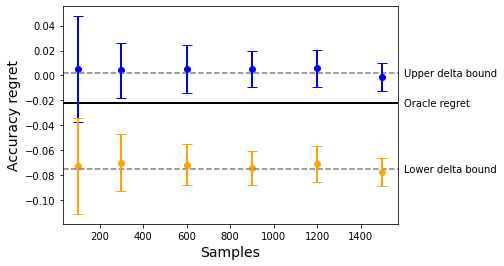

In [7]:
ns_data = experiments.get_est_exp_metadata(coveragedf, Ns)
ns_data = ns_data[ns_data['metric'] == 'm_u']

oracle_up = ns_data['Rd_up_oracle'].tolist()[-1]
oracle_down = ns_data['Rd_down_oracle'].tolist()[-1]
oracle = ns_data['R_oracle'].tolist()[-1]
ns_data = ns_data.iloc[:-1,:]

plt.axhline(oracle_up, color='grey', linestyle='--')
plt.axhline(oracle_down, color='grey', linestyle='--')
plt.axhline(oracle, color='k', linewidth=2,label='$R^*$')

plt.scatter(ns_data['N'], ns_data['Rd_up_pl_mean'], color='blue')
for ix,n in enumerate(ns_data['N']):
    plt.errorbar(n, ns_data['Rd_up_pl_mean'].tolist()[ix], yerr=ns_data['Rd_up_pl_ci'].tolist()[ix],capsize=5, linewidth=2, elinewidth=2, color='blue')

plt.scatter(ns_data['N'], ns_data['Rd_down_pl_mean'], color='orange')
for ix,n in enumerate(ns_data['N']):
    plt.errorbar(n, ns_data['Rd_down_pl_mean'].tolist()[ix], yerr=ns_data['Rd_down_pl_ci'].tolist()[ix],capsize=5, linewidth=2, elinewidth=2, color='orange')
    
# Determine the X location for the text boxes (adjust as needed)
x_loc = max(ns_data['N']) + 100  # Adjust the offset (10 here) as needed

# Add text boxes
plt.text(x_loc, oracle_up, 'Upper delta bound', va='center')
plt.text(x_loc, oracle_down, r'Lower delta bound', va='center', clip_on=False)
plt.text(x_loc, oracle, 'Oracle regret', va='center')

plt.xlabel('Samples', fontsize=14)
plt.ylabel('Accuracy regret', fontsize=14)

Text(0, 0.5, 'Coverage (%)')

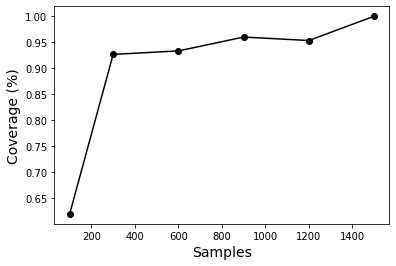

In [8]:
samples = coveragedf[(coveragedf['est_method'] == 'plugin') & (coveragedf['metric'] == 'm_u')]
coverage = samples.groupby('N').mean()['Rd_coverage'].tolist()[:-1]
N = samples.groupby('N').mean().reset_index()['N'].tolist()[:-1]

plt.plot(N, coverage, marker='o', color='k')
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Coverage (%)', fontsize=14)

# Design sensitivity experiment 
- Delta bounds enable certifying a policy improvement up to a larger magnitude of confounding

In [9]:
Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.5,
    'lambda_star': 1.1
}

msm_dgp = set_dgp_config(dgp, 'MSM')
data = generate_data(msm_dgp)

outcome regression error: 0.16021434499445047
propensitiy error: 0.1805003502468488
outcome regression error: 0.16279513285458097
propensitiy error: 0.1803587983511516
outcome regression error: 0.16045295905790433
propensitiy error: 0.17954785001188833
outcome regression error: 0.16126722202002278
propensitiy error: 0.18068244179148818
outcome regression error: 0.15675682891084491
propensitiy error: 0.1765990937981823
outcome regression error: 0.16324051735704234
propensitiy error: 0.18092213726108072
outcome regression error: 0.15858693234533286
propensitiy error: 0.178515090579016
outcome regression error: 0.1584484435888744
propensitiy error: 0.17987252033457288
outcome regression error: 0.1625007107140135
propensitiy error: 0.1778991271121868
outcome regression error: 0.1594546526769725
propensitiy error: 0.17960669546146715
outcome regression error: 0.15801775544677604
propensitiy error: 0.17541233546748
outcome regression error: 0.16225631833587392
propensitiy error: 0.1796098715

outcome regression error: 0.1598380660274297
propensitiy error: 0.18542466850441525
outcome regression error: 0.15923128868992958
propensitiy error: 0.17402736663693727
outcome regression error: 0.15982339477423468
propensitiy error: 0.18226433497480413
outcome regression error: 0.16199431244307572
propensitiy error: 0.17838758402260935
outcome regression error: 0.16240337305861594
propensitiy error: 0.1811401391380872
outcome regression error: 0.1655453207655863
propensitiy error: 0.18017745853279968
outcome regression error: 0.15852778793407982
propensitiy error: 0.17988482641506284
outcome regression error: 0.15496076776380246
propensitiy error: 0.17851082958086859
outcome regression error: 0.16101124495786534
propensitiy error: 0.17742429548305372
outcome regression error: 0.16002409235552542
propensitiy error: 0.17940353208236717
outcome regression error: 0.16510342955140883
propensitiy error: 0.181426213370413
outcome regression error: 0.16023909795866093
propensitiy error: 0.171

outcome regression error: 0.16243916798563496
propensitiy error: 0.1781203671028043
outcome regression error: 0.16000950763713076
propensitiy error: 0.17261210672654725
outcome regression error: 0.15715196913959317
propensitiy error: 0.18177926442927547
outcome regression error: 0.1582893874070179
propensitiy error: 0.17987614060774063
outcome regression error: 0.1670499681851267
propensitiy error: 0.1847354226607616
outcome regression error: 0.159609842218613
propensitiy error: 0.1763737858724583
outcome regression error: 0.16048371980742718
propensitiy error: 0.17423457449005064
outcome regression error: 0.15965306636924123
propensitiy error: 0.17526243502788133
outcome regression error: 0.15742652591813425
propensitiy error: 0.17889702909723992
outcome regression error: 0.15896512215772354
propensitiy error: 0.1808368992423459
outcome regression error: 0.1615581392763014
propensitiy error: 0.1776544948370358
outcome regression error: 0.16402482710300154
propensitiy error: 0.18417497

outcome regression error: 0.15938036154559312
propensitiy error: 0.18271939315032415
outcome regression error: 0.1613610828140088
propensitiy error: 0.1816531454386779
outcome regression error: 0.1607440002129565
propensitiy error: 0.1725728381566038
outcome regression error: 0.16062220587708825
propensitiy error: 0.1762038390596803
outcome regression error: 0.16027371859145206
propensitiy error: 0.1798423141569668
outcome regression error: 0.15776623122989547
propensitiy error: 0.18185361003378017
outcome regression error: 0.16004636351766985
propensitiy error: 0.17980327421376102
outcome regression error: 0.16352052300641406
propensitiy error: 0.17982724905888217
outcome regression error: 0.16333638632462902
propensitiy error: 0.17937355860363757
outcome regression error: 0.15944744004060615
propensitiy error: 0.17752436643387776
outcome regression error: 0.16491695744229265
propensitiy error: 0.180255880917308
outcome regression error: 0.15698180613320878
propensitiy error: 0.178613

outcome regression error: 0.16231565525447986
propensitiy error: 0.17885133400352698
outcome regression error: 0.15965911761311355
propensitiy error: 0.18440850878150097
outcome regression error: 0.15816539674462932
propensitiy error: 0.1741630229408844
outcome regression error: 0.1637915460060152
propensitiy error: 0.18267058792127722
outcome regression error: 0.1627378244376395
propensitiy error: 0.17789219366406223
outcome regression error: 0.15804680830428408
propensitiy error: 0.17848418803390587
outcome regression error: 0.15842429423404802
propensitiy error: 0.1781223706329347
outcome regression error: 0.16226252747986786
propensitiy error: 0.17845237983487977
outcome regression error: 0.16463441817135954
propensitiy error: 0.1787804926780697
outcome regression error: 0.16004651385456728
propensitiy error: 0.18290122896754604
outcome regression error: 0.15675609288271955
propensitiy error: 0.1794653164533914
outcome regression error: 0.1608099528231308
propensitiy error: 0.17587

outcome regression error: 0.16122188518573335
propensitiy error: 0.17957515137770053
outcome regression error: 0.15717177460432874
propensitiy error: 0.18092992337082553
outcome regression error: 0.15970806751520314
propensitiy error: 0.17187069787560239
outcome regression error: 0.16046530504024464
propensitiy error: 0.18078605859886063
outcome regression error: 0.1628870206848024
propensitiy error: 0.18430841156326114
outcome regression error: 0.16826747369290593
propensitiy error: 0.18604456593790292
outcome regression error: 0.1568178739476719
propensitiy error: 0.17852287204774842
outcome regression error: 0.15571349503626458
propensitiy error: 0.18136549645936736
outcome regression error: 0.1550091406302289
propensitiy error: 0.1743260887493737
outcome regression error: 0.16590191379816638
propensitiy error: 0.17761427470086782
outcome regression error: 0.16208557136515736
propensitiy error: 0.17268847369026794
outcome regression error: 0.15995303778759912
propensitiy error: 0.18

outcome regression error: 0.1572668505043176
propensitiy error: 0.1779180596327761
outcome regression error: 0.15939346673806204
propensitiy error: 0.17967403400803236
outcome regression error: 0.1628369948580695
propensitiy error: 0.17988240558839155
outcome regression error: 0.16029347165329796
propensitiy error: 0.17638364412673904
outcome regression error: 0.1624718107163009
propensitiy error: 0.18436683483815214
outcome regression error: 0.1608668238695817
propensitiy error: 0.1769557152437926
outcome regression error: 0.15872830470639834
propensitiy error: 0.1797698921058781
outcome regression error: 0.15697660702070634
propensitiy error: 0.17175918813883673
outcome regression error: 0.16409340267661418
propensitiy error: 0.18039826938817086
outcome regression error: 0.1615511082700759
propensitiy error: 0.18901095660692044
outcome regression error: 0.15887576512456383
propensitiy error: 0.18252771728048464
outcome regression error: 0.16452292281132197
propensitiy error: 0.175329

outcome regression error: 0.1577752926276011
propensitiy error: 0.17608522361392093
outcome regression error: 0.16550514293733376
propensitiy error: 0.1812347534512607
outcome regression error: 0.15494487757174488
propensitiy error: 0.18236509233261122
outcome regression error: 0.1651741286011058
propensitiy error: 0.18272095087842916
outcome regression error: 0.1584702065860609
propensitiy error: 0.17543222325681948
outcome regression error: 0.16042503883570017
propensitiy error: 0.18060364319016692
outcome regression error: 0.16278051842015406
propensitiy error: 0.17846830693515048
outcome regression error: 0.16124653213098328
propensitiy error: 0.18414768000086054
outcome regression error: 0.1565028212019004
propensitiy error: 0.17778416425352866
outcome regression error: 0.16086282858137135
propensitiy error: 0.1771720595414451
outcome regression error: 0.16415362044040538
propensitiy error: 0.17987842322501837
outcome regression error: 0.15619429294290482
propensitiy error: 0.1775

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


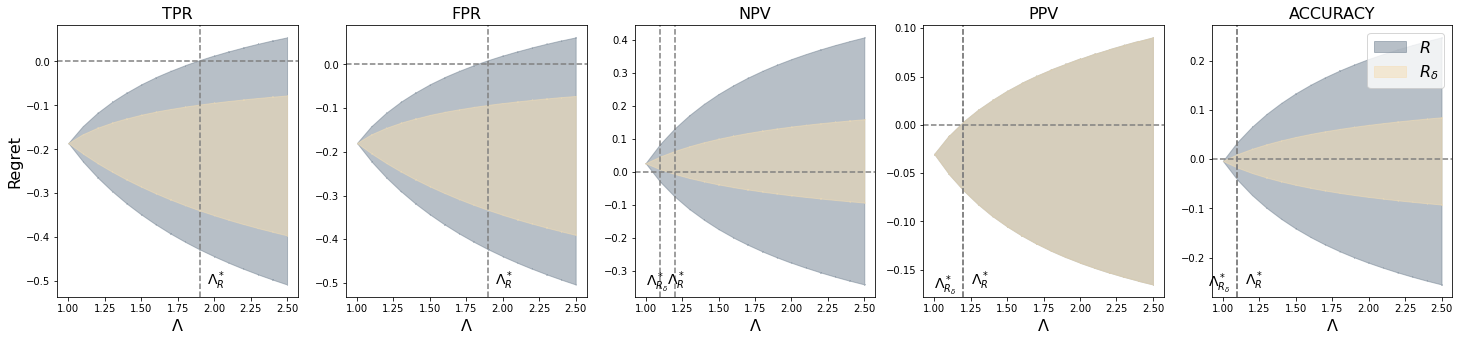

In [10]:
lambdas = np.arange(1, 2.6, .1)
brdf = experiments.design_sensitivity_exp(dgp, data, lambdas, n_sims=10)
plots.plot_design_sensitivity(brdf)

# Experiment: Exclusion restriction violation tests

outcome regression error: 0.026934444690664413
propensitiy error: 0.03501023907602709
outcome regression error: 0.026174598937062463
propensitiy error: 0.03583522523451803
outcome regression error: 0.02685841399728094
propensitiy error: 0.03553326755592403
outcome regression error: 0.026085532231612963
propensitiy error: 0.0340056702025885
outcome regression error: 0.026714199954245833
propensitiy error: 0.03463278361026029
outcome regression error: 0.026014917498294633
propensitiy error: 0.034341361180381065
outcome regression error: 0.02595270617264093
propensitiy error: 0.033521060235095095
outcome regression error: 0.025820440423512985
propensitiy error: 0.0341619762181774
outcome regression error: 0.026089615986970006
propensitiy error: 0.03396289325152976
outcome regression error: 0.025880521236537953
propensitiy error: 0.03379598194964142
outcome regression error: 0.027356701610741958
propensitiy error: 0.035401948226909424
outcome regression error: 0.02620883685472834
propensit

outcome regression error: 0.026552035725969276
propensitiy error: 0.033325736761319516
outcome regression error: 0.02663014026560819
propensitiy error: 0.03416660651586357
outcome regression error: 0.025608587964041453
propensitiy error: 0.03260311474884632
outcome regression error: 0.027385724324807525
propensitiy error: 0.034089924168681875
outcome regression error: 0.026614097197338486
propensitiy error: 0.03374977744063355
outcome regression error: 0.027600066724785176
propensitiy error: 0.036383520291025366
outcome regression error: 0.0253696481877884
propensitiy error: 0.03465865022175906
outcome regression error: 0.025884377000826745
propensitiy error: 0.036131550827777616
outcome regression error: 0.026171748342819302
propensitiy error: 0.03563710985974871
outcome regression error: 0.025914325677729926
propensitiy error: 0.03503656371231723
outcome regression error: 0.026578285917243483
propensitiy error: 0.03590816055652448
outcome regression error: 0.026974423507167913
propen

outcome regression error: 0.026889892322371427
propensitiy error: 0.03562441525972614
outcome regression error: 0.025765629790132038
propensitiy error: 0.03526255889654989
outcome regression error: 0.025305734379313903
propensitiy error: 0.034999545375164774
outcome regression error: 0.025818324322099222
propensitiy error: 0.0343689311339664
outcome regression error: 0.026929075331850152
propensitiy error: 0.03400845901670522
outcome regression error: 0.02569218335019896
propensitiy error: 0.0342690608877474
outcome regression error: 0.026003586777746408
propensitiy error: 0.03481916372101415
outcome regression error: 0.02656754882622894
propensitiy error: 0.03493273907535108
outcome regression error: 0.026739558410930446
propensitiy error: 0.034404300813539644
outcome regression error: 0.026597097755935065
propensitiy error: 0.036025222818847555
outcome regression error: 0.025530302835498134
propensitiy error: 0.03323754555009091
outcome regression error: 0.02616968875264313
propensit

outcome regression error: 0.025713185101966508
propensitiy error: 0.033655781450579396
outcome regression error: 0.026201501498255272
propensitiy error: 0.03382967514958868
outcome regression error: 0.025602492371868017
propensitiy error: 0.03393295456355813
outcome regression error: 0.025953532389902237
propensitiy error: 0.033782630224641085
outcome regression error: 0.02556738511863187
propensitiy error: 0.033684545004946116
outcome regression error: 0.02499838509643418
propensitiy error: 0.03413727444637717
outcome regression error: 0.026323288930735197
propensitiy error: 0.03512398901868714
outcome regression error: 0.025710784020426265
propensitiy error: 0.03453668642437854
outcome regression error: 0.025960925205760106
propensitiy error: 0.03402585684191546
outcome regression error: 0.025946610888154142
propensitiy error: 0.03414991682456599
outcome regression error: 0.02591933593823939
propensitiy error: 0.034950040999148606
outcome regression error: 0.026534810181999453
propen

outcome regression error: 0.0249550262402257
propensitiy error: 0.036167196838932214
outcome regression error: 0.024520384893909467
propensitiy error: 0.035865035030062796
outcome regression error: 0.025159527947646778
propensitiy error: 0.03442300572490608
outcome regression error: 0.025457651606140417
propensitiy error: 0.034702416050653974
outcome regression error: 0.025649441670236365
propensitiy error: 0.03650182219098765
outcome regression error: 0.025408374684931158
propensitiy error: 0.03443911711955766
outcome regression error: 0.02532000404661692
propensitiy error: 0.033820942957899815
outcome regression error: 0.025815065806254024
propensitiy error: 0.03554381800848028
outcome regression error: 0.02554639180105327
propensitiy error: 0.03428280118089533
outcome regression error: 0.025984241881573396
propensitiy error: 0.03530071867079118
outcome regression error: 0.026368038161046065
propensitiy error: 0.03565297381476725
outcome regression error: 0.02606131349676431
propensi

outcome regression error: 0.02629542249706933
propensitiy error: 0.03629611347947264
outcome regression error: 0.025092376884259658
propensitiy error: 0.034718571819769034
outcome regression error: 0.025134177217098697
propensitiy error: 0.036374842934071644
outcome regression error: 0.025518114234721827
propensitiy error: 0.03522443438513131
outcome regression error: 0.025822890854602334
propensitiy error: 0.03681482034552469
outcome regression error: 0.027128974917089495
propensitiy error: 0.03517454483407187
outcome regression error: 0.02736111994317154
propensitiy error: 0.03464017264523924
outcome regression error: 0.02638095645349041
propensitiy error: 0.036039467627122526
outcome regression error: 0.027567145102245963
propensitiy error: 0.034995965171014914
outcome regression error: 0.02613105082085024
propensitiy error: 0.03401161706325077
outcome regression error: 0.026050950817393895
propensitiy error: 0.03501741065278257
outcome regression error: 0.027177589972999832
propens

outcome regression error: 0.026167910857940478
propensitiy error: 0.03236863641060157
outcome regression error: 0.0254589233476167
propensitiy error: 0.03290438052856294
outcome regression error: 0.025643227519564604
propensitiy error: 0.03374198086033472
outcome regression error: 0.025945303464771988
propensitiy error: 0.0338970138619437
outcome regression error: 0.026830601374757544
propensitiy error: 0.03413416668027259
outcome regression error: 0.026320379066457903
propensitiy error: 0.03532914342827628
outcome regression error: 0.02551159598666945
propensitiy error: 0.034810765015219396
outcome regression error: 0.024964579991447786
propensitiy error: 0.03589744011266092
outcome regression error: 0.026154750776996
propensitiy error: 0.03672660674476068
outcome regression error: 0.02556689850833662
propensitiy error: 0.03549752253470839
outcome regression error: 0.025407303262522083
propensitiy error: 0.03643340531358164
outcome regression error: 0.02751236627914156
propensitiy err

outcome regression error: 0.027745088853289742
propensitiy error: 0.03454044675254036
outcome regression error: 0.026914210568526484
propensitiy error: 0.035085426719144205
outcome regression error: 0.025773108907228545
propensitiy error: 0.034684402446510054
outcome regression error: 0.025766038600963624
propensitiy error: 0.03509885615915319
outcome regression error: 0.02571955756231472
propensitiy error: 0.03409136226878268
outcome regression error: 0.025798135681693354
propensitiy error: 0.0346974369962679
outcome regression error: 0.027181953126402175
propensitiy error: 0.03451232297784547
outcome regression error: 0.026415359458837922
propensitiy error: 0.036051973461819445
outcome regression error: 0.02563344472935665
propensitiy error: 0.0348042855216865
outcome regression error: 0.02606173064060164
propensitiy error: 0.03449760077339582
outcome regression error: 0.027531896118840948
propensitiy error: 0.034953833983557045
outcome regression error: 0.027031145898295642
propensi

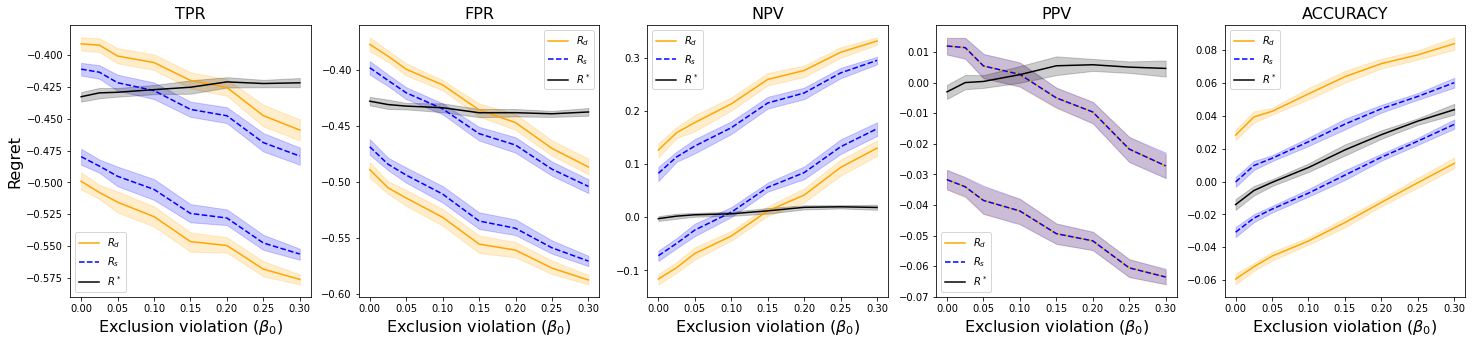

In [3]:
lambda_star = 1.1
lambdas = np.arange(1, 2.6, .1)
Nsims = 10

Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 20000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.5,
    'lambda_star': 1.7,
    'id_assumption': 'IV'
}

dgp = set_dgp_config(dgp, 'IV')
beta_zy = [0, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
bedf = experiments.exclusion_sensitivity_experiment(dgp, beta_zy, n_sims=20, est_method='plugin', K=5)
plots.plot_exclusion_sensitivity(bedf)

# Experiment: Relevance violation tests

outcome regression error: 0.10387089802923943
propensitiy error: 0.06020638320888023
outcome regression error: 0.09941494093943856
propensitiy error: 0.05730679574385052
outcome regression error: 0.10110315813872381
propensitiy error: 0.05923540906808636
outcome regression error: 0.10301635848417473
propensitiy error: 0.05866337986969966
outcome regression error: 0.10152143211529281
propensitiy error: 0.058374675447753294
outcome regression error: 0.09672355558270222
propensitiy error: 0.0562403761392945
outcome regression error: 0.09531622495004567
propensitiy error: 0.05462733811959149
outcome regression error: 0.09995264617537253
propensitiy error: 0.05865309180354838
outcome regression error: 0.09743261133913518
propensitiy error: 0.05840598441955706
outcome regression error: 0.0992068458661887
propensitiy error: 0.05947147781206586
outcome regression error: 0.09924858091702504
propensitiy error: 0.058477924941911785
outcome regression error: 0.09754144672411741
propensitiy error: 

outcome regression error: 0.10373686780526893
propensitiy error: 0.0578999452103274
outcome regression error: 0.10160194927718993
propensitiy error: 0.05756114682078952
outcome regression error: 0.09479971291542282
propensitiy error: 0.05617142036085659
outcome regression error: 0.09433234400314275
propensitiy error: 0.053332806749971685
outcome regression error: 0.09781548340111579
propensitiy error: 0.05679857755565446
outcome regression error: 0.0953256393034157
propensitiy error: 0.057006756639629175
outcome regression error: 0.09734689764315678
propensitiy error: 0.05560840811220355
outcome regression error: 0.09895847233040134
propensitiy error: 0.05753983501957197
outcome regression error: 0.09867959383863405
propensitiy error: 0.05672667427830852
outcome regression error: 0.10015165037677978
propensitiy error: 0.057508560938375475
outcome regression error: 0.10051014649193149
propensitiy error: 0.05717427783407507
outcome regression error: 0.09874666262242328
propensitiy error:

outcome regression error: 0.09956763955224389
propensitiy error: 0.05375898718555442
outcome regression error: 0.09904242686792536
propensitiy error: 0.05418848310873249
outcome regression error: 0.09851233553122947
propensitiy error: 0.05281320822988793
outcome regression error: 0.09938967752358274
propensitiy error: 0.05236241238366891
outcome regression error: 0.10003891120376318
propensitiy error: 0.05476417559643614
outcome regression error: 0.10125960479466652
propensitiy error: 0.05613763235532014
outcome regression error: 0.09840718515029662
propensitiy error: 0.05203307397893104
outcome regression error: 0.0989907050792935
propensitiy error: 0.052733562356467666
outcome regression error: 0.09794952298833096
propensitiy error: 0.05116227039372838
outcome regression error: 0.09869723524698282
propensitiy error: 0.052717843128785566
outcome regression error: 0.09730509182485222
propensitiy error: 0.05351917142145162
outcome regression error: 0.09944134236493124
propensitiy error:

outcome regression error: 0.0989373257670671
propensitiy error: 0.04836188170981791
outcome regression error: 0.10076175279796575
propensitiy error: 0.05110024625112368
outcome regression error: 0.09881428984208664
propensitiy error: 0.04750009886455394
outcome regression error: 0.10131942936180195
propensitiy error: 0.04592525921054278
outcome regression error: 0.09878200440122756
propensitiy error: 0.04590549386234218
outcome regression error: 0.0980155883901816
propensitiy error: 0.0462927487500641
outcome regression error: 0.09876656300808398
propensitiy error: 0.04690578683638658
outcome regression error: 0.10023657474279292
propensitiy error: 0.04744554270037858
outcome regression error: 0.09681281635582181
propensitiy error: 0.046016075591855596
outcome regression error: 0.09894838540512606
propensitiy error: 0.04649293138912285
outcome regression error: 0.09888563795943989
propensitiy error: 0.04612563089142409
outcome regression error: 0.09738702665746798
propensitiy error: 0.

outcome regression error: 0.09730264181203449
propensitiy error: 0.04228434309413435
outcome regression error: 0.09636456329159342
propensitiy error: 0.04427789093238506
outcome regression error: 0.10022824018056395
propensitiy error: 0.046024256121614086
outcome regression error: 0.09920292131920541
propensitiy error: 0.0453578023179417
outcome regression error: 0.1010266269142867
propensitiy error: 0.04539760363021007
outcome regression error: 0.10059202309409421
propensitiy error: 0.04719154820336433
outcome regression error: 0.09829388546992786
propensitiy error: 0.042658418088722144
outcome regression error: 0.09962170482751742
propensitiy error: 0.03956753506562518
outcome regression error: 0.09611015308546979
propensitiy error: 0.04123119315141562
outcome regression error: 0.0980029030824344
propensitiy error: 0.04144535303284148
outcome regression error: 0.09467981865353439
propensitiy error: 0.04068822890215483
outcome regression error: 0.09987578568268017
propensitiy error: 0

outcome regression error: 0.09590087239295711
propensitiy error: 0.037495319347109216
outcome regression error: 0.09704965129921281
propensitiy error: 0.03560255374445269
outcome regression error: 0.09762760875357424
propensitiy error: 0.03630819847369348
outcome regression error: 0.09874577131166092
propensitiy error: 0.036435156629867425
outcome regression error: 0.09971720720590374
propensitiy error: 0.03942380449457586
outcome regression error: 0.09605217683203932
propensitiy error: 0.03710195906876903
outcome regression error: 0.09752412612436528
propensitiy error: 0.037674889017418736
outcome regression error: 0.09717394989618094
propensitiy error: 0.03583234611981884
outcome regression error: 0.09666878828045593
propensitiy error: 0.03792261023120442
outcome regression error: 0.0995021783860507
propensitiy error: 0.03752400881687521
outcome regression error: 0.09567620055904681
propensitiy error: 0.035500722562306415
outcome regression error: 0.09697391282500625
propensitiy erro

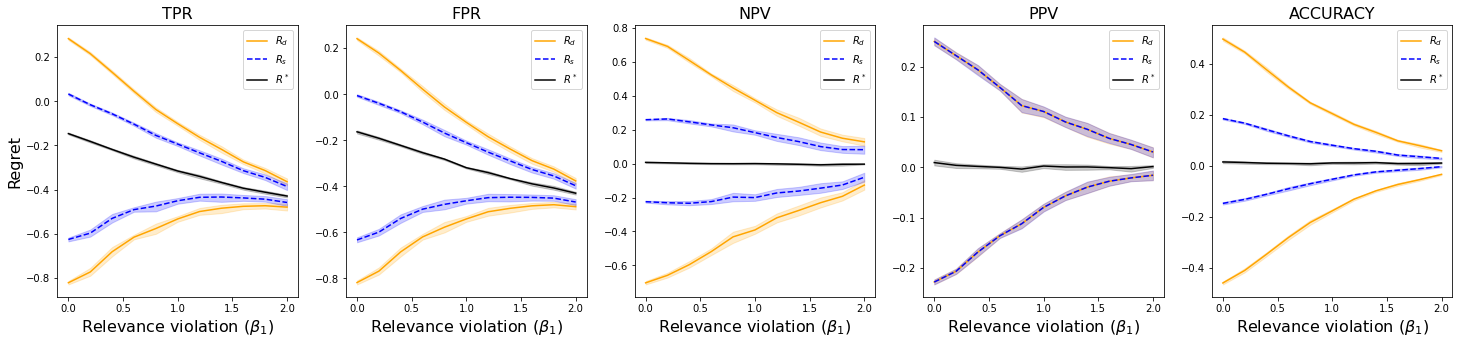

In [5]:
lambdas = np.arange(1, 2.6, .1)
Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.5,
    'lambda_star': 1.7,
    'id_assumption': 'IV'
}

iv_dgp = set_dgp_config(dgp, 'IV')
beta_zd = [0, .2, .4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
brdf = experiments.relevance_sensitivity_experiment(iv_dgp, beta_zd, n_sims=10)
plots.plot_relevance_sensitivity(brdf)


## Robustness check: MSM $\Lambda$ coverage

In [ ]:
lambda_star = 1.1
lambdas = np.arange(1, 2.6, .1)
Nsims = 10

Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 1.2,
    'id_assumption': 'MSM'
}

msm_dgp = set_dgp_config(dgp, 'MSM')
lambda_star = [0, .2, .4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4]

msm_bounds = []

for ls in lambda_star:
    
    msm_dgp['lambda_star'] = ls
    
    for sim in range(Nsims):
        
        data = generate_data(msm_dgp)
        bounds = estimation.estimate_bounds(msm_dgp, data, id_method='MSM', est_method='plugin', K=5)
        bounds['ls'] = ls
        msm_bounds.append(bounds)

msmdf = pd.concat(msm_bounds)


outcome regression error: 0.06306213333649777
propensitiy error: 0.04717686353493241
outcome regression error: 0.06298850589677502
propensitiy error: 0.04880636656187194
outcome regression error: 0.06323146186546313
propensitiy error: 0.04752673375712506
outcome regression error: 0.06343354141103343
propensitiy error: 0.047435428202784076
outcome regression error: 0.06529492850889014
propensitiy error: 0.047900202160420506
outcome regression error: 0.06206036408677522
propensitiy error: 0.048326336654901034
outcome regression error: 0.06371852136919665
propensitiy error: 0.04951196452195138
outcome regression error: 0.06292815472552343
propensitiy error: 0.048597746364107096
outcome regression error: 0.06139170100475165
propensitiy error: 0.04689333306321694
outcome regression error: 0.061606961600921065
propensitiy error: 0.047550746689009014
outcome regression error: 0.06292661855499418
propensitiy error: 0.0485343375160434
outcome regression error: 0.06198375895980041
propensitiy er

outcome regression error: 0.06495337780366048
propensitiy error: 0.04893570237324099
outcome regression error: 0.06182327156370262
propensitiy error: 0.047418461250588816
outcome regression error: 0.06449776244539096
propensitiy error: 0.04769260201917603
outcome regression error: 0.06415990828478517
propensitiy error: 0.048999772927540826
outcome regression error: 0.06700167478401141
propensitiy error: 0.049056478781033745
outcome regression error: 0.06742607807351653
propensitiy error: 0.04922026375668296
outcome regression error: 0.06457855139051162
propensitiy error: 0.0480929255973556
outcome regression error: 0.06452043436614849
propensitiy error: 0.050795285509539115
outcome regression error: 0.06423778875411594
propensitiy error: 0.05015039521586589
outcome regression error: 0.06298129566915278
propensitiy error: 0.049571572435522786
outcome regression error: 0.06022602203859036
propensitiy error: 0.04944787895012864
outcome regression error: 0.06185584787741661
propensitiy err

outcome regression error: 0.06527473535941647
propensitiy error: 0.049915593005178775
outcome regression error: 0.062361359210183445
propensitiy error: 0.049742029394616014
outcome regression error: 0.0630745712423749
propensitiy error: 0.04942849172480217
outcome regression error: 0.0635216231641749
propensitiy error: 0.04759127922495589
outcome regression error: 0.06350377230788122
propensitiy error: 0.04935305599664537
outcome regression error: 0.06553571531678684
propensitiy error: 0.04970669578975462
outcome regression error: 0.06287416415828492
propensitiy error: 0.04877229712254688
outcome regression error: 0.06300149226206234
propensitiy error: 0.04840385985014846
outcome regression error: 0.062094264681612395
propensitiy error: 0.049258419546642646
outcome regression error: 0.06307574800961462
propensitiy error: 0.04962143530874493
outcome regression error: 0.06171816603364547
propensitiy error: 0.04822363493713478
outcome regression error: 0.06179972763224639
propensitiy erro

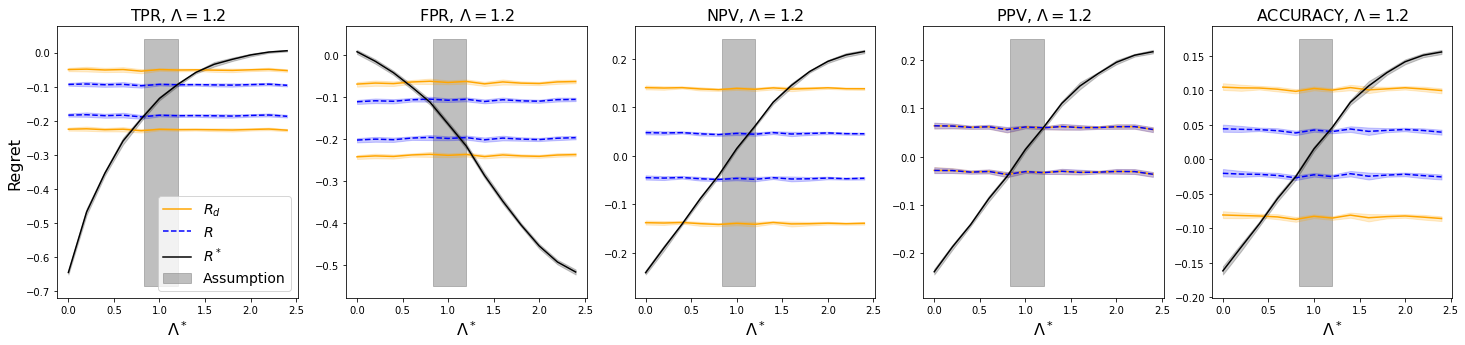

In [7]:


lam = msm_dgp['lambda']

metrics = msmdf['metric'].unique().tolist()

fig, axes = plt.subplots(1, 5, figsize=(25, 5)) # Adjust the figsize as needed

for i, metric in enumerate(metrics):
    
    # Filter the DataFrame for the current metric
    metric_df = msmdf[msmdf['metric'] == metric]
    
    # Reset the index to avoid the duplicate labels error
    metric_df = metric_df.reset_index(drop=True)
    ymin = metric_df[['Rs_down', 'Rs_up', 'Rd_down', 'Rd_up', 'R_oracle']].min().min()
    ymax = metric_df[['Rs_down', 'Rs_up', 'Rd_down', 'Rd_up', 'R_oracle']].max().max()
    
    # Create each lineplot on the corresponding subplot axis
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='Rs_up', color='orange', linestyle='-', label='$R_d$')
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='Rs_down', color='orange', linestyle='-')
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='Rd_up', color='blue', linestyle='--', label='$R$')
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='Rd_down', color='blue', linestyle='--')
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='R_oracle', color='black', label='$R^*$')

    # Set the titles, labels, etc.
    axes[i].set_xlabel(r'$\Lambda^*$', fontsize=16)
    axes[i].set_title(f'{utils.metric_dict[metric]}, $\Lambda={lam}$', fontsize=16)
    axes[i].set_ylabel(f'', fontsize=16)
    
    ymin, ymax = axes[i].get_ylim()
    axes[i].fill_between([lam**-1, lam], ymin, ymax, color='grey',
                         alpha=0.5, zorder=-1, label='Assumption')
    axes[i].legend().set_visible(False)
    

    
axes[0].set_ylabel(f'Regret', fontsize=16)
axes[0].legend(fontsize=14)